<a href="https://colab.research.google.com/github/KyoungmiKwon/trainingAtAiffel/blob/main/DL01_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from PIL import Image
import glob
import os

In [3]:
from PIL import Image
import glob
import os

def resize_images(img_path):
        images=glob.glob(img_path + "/*.jpg")

        print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
        target_size=(28,28)
        for img in images:
                old_img=Image.open(img)
                new_img=old_img.resize(target_size,Image.Resampling.LANCZOS)
                new_img.save(img, "JPEG")

        print(len(images), " images resized.")

In [8]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path ='/content/drive/MyDrive/Colab Notebooks/Aiffel/3'
resize_images(image_dir_path)

print("이미지 resize 완료!")

100  images to be resized.
100  images resized.
이미지 resize 완료!


In [25]:
from PIL import Image

# 이미지 경로 지정
img_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/test/paper/1.jpg'  # 예시 경로: 적절히 수정하세요

# 이미지 열기
img = Image.open(img_path)

# 이미지 크기 출력 (가로, 세로)
print("이미지 크기:", img.size)  # 예: (width, height)

이미지 크기: (28, 28)


In [5]:
import numpy as np

from sklearn.utils import shuffle


def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


In [12]:
image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/test'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


In [8]:
type(x_train)

numpy.ndarray

라벨:  0


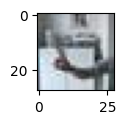

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 1))
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', # 모니터링 할 지표 'loss', ('min','mse', 'mae', 'AUC', 'Precision', 'Recall', 'F1Score' 등)
                         # model.compile()에서 지정한 추가 지표를 사용할 경우 'val_'을 붙여야 함 -> 'val_mae', 'val_accuracy' 등
    verbose=1,           # 훈련 중에 조기 중단이 발생하면 메시지를 출력합니다.
    min_delta=0.001,     # 개선으로 간주되는 최소 변화량# min_delta는 개선으로 간주되는 최소 변화량입니다.
    patience=2,          # 5 에포크 동안 개선이 없으면 중단
    mode='min',          # val_loss는 최소화되는 것이 좋
    restore_best_weights=True # 가장 성능이 좋았던 에포크의 가중치로 복원
)

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train, y_train,
          validation_data=(x_train_norm, y_train), # <--- 이 부분이 추가되어야 합니다! (early_stopping_callback을 사용할 때)
          epochs=10)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_train_norm, y_train, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,050 (121.29 KB)

 Trainable params: 31,050 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.2586 - loss: 22.5202 - val_accuracy: 0.3433 - val_loss: 2.0987
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3718 - loss: 9.2138 - val_accuracy: 0.4433 - val_loss: 2.1082
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5045 - loss: 3.6555 - val_accuracy: 0.5567 - val_loss: 2.1241
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6562 - loss: 1.8742 - val_accuracy: 0.6200 - val_loss: 2.1378
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6660 - loss: 1.2428 - val_accuracy: 0.7633 - val_loss: 2.1431
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7530 - loss: 0.9068 - val_accuracy: 0.7967 - val_loss: 2.1510
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8250 - loss: 0.4754 - val_accuracy: 0.7600 - val_loss: 2.1572
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7647 - loss: 0.8434 - val_accuracy: 0.7167 - 

In [25]:
# test 할 데이터 불러오기
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path ='/content/drive/MyDrive/Colab Notebooks/Aiffel/test/data/scissor'
resize_images(image_dir_path)

print("이미지 resize 완료!")

100  images to be resized.
100  images resized.
이미지 resize 완료!


In [28]:
image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Aiffel/test/data'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


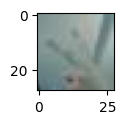

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 1))
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [30]:
test_loss, test_accuracy = model.evaluate(x_train_norm, y_train, verbose=2)

10/10 - 0s - 17ms/step - accuracy: 0.3267 - loss: 2.2234


In [31]:
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

test_loss: 2.2234418392181396 
test_accuracy: 0.3266666531562805
